In [1]:
import pathlib
pathlib.PosixPath = pathlib.WindowsPath
from core.perception.scene_perception import cal_iou, load_yolo, detect_objects

yolo_path = "./core/models/yolo_sim.pt"
yolo = load_yolo(yolo_path)
class_map = {k: ('pot' if v == 'pan' else v) for k, v in yolo.names.items()}

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\arman/.cache\torch\hub\master.zip
YOLOv5  2025-8-26 Python-3.8.10 torch-2.4.1+cpu CPU



In [6]:
%matplotlib inline
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict, Counter
from scipy.optimize import linear_sum_assignment
import pybullet as p
import pybullet_data
from core.sim.physics_utils import PyBulletSim, load_table_urdf, get_object_extents
from core.sim.camera_manager import CameraManager
from core.env.scene_manager import OBJECTS, Indices, build_child_of
from core.sim.rearrangement_loader import world_to_grid_coords
from core.perception.spatial_relation_inference import compute_scene_relation_graph, load_model
from core.perception.scene_perception import plot_detections, consensus_filter, instance_matching
OBJS_DIR = os.path.join('core', 'sim', 'objects')

def sort_and_validate_detections(label_file_path, detections, class_map):
	"""
	Sorts detected objects against a ground-truth label file for validation.
	
	This ensures the initial scene's detections match the ground truth object IDs.
	"""
	# (The rest of your function code remains the same)
	with open(label_file_path, 'r') as f:
		labels = json.load(f)
	gt_objects = sorted(labels['objects'], key=lambda x: x['obj_id'])
	if len(detections) != len(gt_objects):
		raise ValueError(f"Object count mismatch. GT: {len(gt_objects)}, Detected: {len(detections)}.")
	id_to_name = {v: k for k, v in class_map.items()}
	gt_by_class = defaultdict(list)
	for gt_obj in gt_objects:
		gt_class_id = id_to_name.get(gt_obj['model_name'])
		if gt_class_id is None:
			raise ValueError(f"Model name '{gt_obj['model_name']}' not in class_map.")
		gt_by_class[gt_class_id].append(gt_obj)
	det_by_class = defaultdict(list)
	for d in detections:
		det_by_class[d['class']].append(d)
	if Counter(k for k in gt_by_class) != Counter(k for k in det_by_class):
		raise ValueError(f"Class mismatch. GT: {Counter(k for k in gt_by_class)}, Det: {Counter(k for k in det_by_class)}")
	sorted_det = [None] * len(gt_objects)
	for class_id, gts in gt_by_class.items():
		dets = det_by_class[class_id]
		if len(gts) != len(dets):
			raise ValueError(f"Count mismatch for class {class_id}. GT: {len(gts)}, Detected: {len(dets)}.")
		cost_matrix = np.zeros((len(gts), len(dets)))
		for i, gt_obj in enumerate(gts):
			for j, detected_obj in enumerate(dets):
				iou = cal_iou(gt_obj['bbox'], detected_obj['bbox'])
				cost_matrix[i, j] = 1 - iou
		gt_indices, det_indices = linear_sum_assignment(cost_matrix)
		for gt_idx, det_idx in zip(gt_indices, det_indices):
			gt_obj_id = gts[gt_idx]['obj_id']
			sorted_det[gt_obj_id] = dets[det_idx]
	if any(d is None for d in sorted_det):
		unassigned_ids = [i for i, d in enumerate(sorted_det) if d is None]
		raise RuntimeError(f"Failed to assign all objects. Unassigned GT IDs: {unassigned_ids}")
	return sorted_det

def create_x_from_det(det_init, det_trgt, init_pairs, trgt_pairs, viewpoint_id, class_map):
	num_objects = len(det_init)

	sim = PyBulletSim(p.DIRECT)
	grid_size = (100, 100)
	table = load_table_urdf(OBJS_DIR, grid_size)
	z = get_object_extents(table)[2]
	cam = CameraManager()
	cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=viewpoint_id)

	x_init = torch.zeros((num_objects, num_objects+5), dtype=torch.long)
	x_trgt = torch.zeros((num_objects, num_objects+5), dtype=torch.long)
	for i in range(len(det_init)):
		model_name = class_map[det_init[i]['class']]
		label = next((k for k, v in OBJECTS.items() if v['name'] == model_name), None)
		size = OBJECTS[label]['size']
		bbox = det_init[i]['bbox']
		u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
		obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
		grid_pos = world_to_grid_coords(obj_pos, grid_size=grid_size)
		x_init[i, 0] = label
		x_init[i, 1] = size[0]
		x_init[i, 2] = size[1]
		x_init[i, 3] = grid_pos[0]
		x_init[i, 4] = grid_pos[1]

		bbox = det_trgt[i]['bbox']
		u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
		obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
		grid_pos = world_to_grid_coords(obj_pos, grid_size=grid_size)
		x_trgt[i, 0] = label
		x_trgt[i, 1] = size[0]
		x_trgt[i, 2] = size[1]
		x_trgt[i, 3] = grid_pos[0]
		x_trgt[i, 4] = grid_pos[1]
	
	sim.close()

	for stacked_id, base_id in init_pairs:
		child_of = build_child_of(x_init)
		desc_mask = torch.zeros(num_objects, dtype=torch.bool)
		cur = stacked_id
		while cur >= 0:
			desc_mask[cur] = True
			cur = int(child_of[cur])

		x_init[desc_mask, Indices.COORD] = x_init[base_id, Indices.COORD].clone().view(1,2)
		x_init[stacked_id, Indices.RELATION.start + base_id] = 1

	for stacked_id, base_id in trgt_pairs:
		child_of = build_child_of(x_trgt)
		desc_mask = torch.zeros(num_objects, dtype=torch.bool)
		cur = stacked_id
		while cur >= 0:
			desc_mask[cur] = True
			cur = int(child_of[cur])

		# Bulk‐assign new center to every object in the chain
		x_trgt[desc_mask, Indices.COORD] = x_trgt[base_id, Indices.COORD].clone().view(1,2)
		x_trgt[stacked_id, Indices.RELATION.start + base_id] = 1

	return x_init, x_trgt

def validate_stack_relations(meta_path, x_init, x_trgt):
    """
    Validates stacking relations against ground truth, accounting for instance ambiguity.

    For the initial scene, it performs a strict check of object IDs.
    
    For the target scene, it handles ambiguity from instance matching. A direct ID
    comparison is tried first. If it fails, it falls back to a more lenient check.
    This check groups relations by the class of the child object and verifies that
    the multiset of parent classes for each group is consistent.
    
    This correctly handles cases where parent objects OF THE SAME CLASS are swapped
    for children of a specific class, while correctly FAILING if parents of
    DIFFERENT classes are swapped.
    """
    with open(meta_path, 'r') as f:
        meta = json.load(f)

    num_objects = x_init.shape[0]
    all_correct = True

    # --- Extract Ground Truth Relations ---
    gt_init_relations = set()
    gt_trgt_relations = set()
    for obj in meta['objects']:
        child_id = obj['object_id']
        if obj['initial_base_id'] is not None:
            gt_init_relations.add((child_id, obj['initial_base_id']))
        if obj['target_base_id'] is not None:
            gt_trgt_relations.add((child_id, obj['target_base_id']))

    # --- Extract Detected Relations ---
    detected_init_relations = set()
    for child_id in range(num_objects):
        parent_ids = torch.where(x_init[child_id, Indices.RELATION] == 1)[0]
        for parent_id in parent_ids:
            detected_init_relations.add((child_id, int(parent_id)))

    detected_trgt_relations = set()
    for child_id in range(num_objects):
        parent_ids = torch.where(x_trgt[child_id, Indices.RELATION] == 1)[0]
        for parent_id in parent_ids:
            detected_trgt_relations.add((child_id, int(parent_id)))

    print("\n--- Stack Relation Validation ---")

    # --- 1. Validate Initial Scene (Strict Matching) ---
    # (This section remains unchanged)
    print("\n[Initial Scene]")
    print(f"  - Ground Truth: {sorted(list(gt_init_relations)) if gt_init_relations else 'No stacks'}")
    print(f"  - Detected:     {sorted(list(detected_init_relations)) if detected_init_relations else 'No stacks'}")
    if gt_init_relations == detected_init_relations:
        print("  - ✅ Correct")
    else:
        print("  - ❌ Incorrect")
        all_correct = False
        # (Error reporting remains unchanged)

    # --- 2. Validate Target Scene (Corrected Two-Level Check) ---
    print("\n[Target Scene]")
    print(f"  - Ground Truth (by ID): {sorted(list(gt_trgt_relations)) if gt_trgt_relations else 'No stacks'}")
    print(f"  - Detected (by ID):     {sorted(list(detected_trgt_relations)) if detected_trgt_relations else 'No stacks'}")

    if gt_trgt_relations == detected_trgt_relations:
        print("  - ✅ Correct (Strict ID match)")
    else:
        # Strict match failed. Now perform the class-based grouping check.
        object_class_labels = x_init[:, 0].tolist()

        def _get_grouped_parent_classes(relations, class_labels):
            """
            Groups relations by the child's class.
            Returns a dict where:
              key = child_class
              value = Counter of parent_classes for that child_class
            """
            grouped = defaultdict(list)
            for child_id, parent_id in relations:
                child_class = class_labels[child_id]
                parent_class = class_labels[parent_id]
                grouped[child_class].append(parent_class)
            
            # Convert lists to Counters for permutation-invariant comparison
            return {k: Counter(v) for k, v in grouped.items()}

        gt_grouped_parents = _get_grouped_parent_classes(gt_trgt_relations, object_class_labels)
        detected_grouped_parents = _get_grouped_parent_classes(detected_trgt_relations, object_class_labels)

        print("  - Comparing parent classes, grouped by child class...")
        
        if gt_grouped_parents == detected_grouped_parents:
            print("  - ✅ Correct (Class-based match)")
        else:
            print("  - ❌ Incorrect (Class-based mismatch)")
            all_correct = False
            # Provide more detailed error info
            all_keys = set(gt_grouped_parents.keys()) | set(detected_grouped_parents.keys())
            for key in sorted(list(all_keys)):
                gt_parents = gt_grouped_parents.get(key, Counter())
                det_parents = detected_grouped_parents.get(key, Counter())
                if gt_parents != det_parents:
                    print(f"    - Mismatch for child class '{key}':")
                    print(f"      - Expected Parents: {dict(gt_parents)}")
                    print(f"      - Got Parents:      {dict(det_parents)}")

    print("-" * 33 + "\n")
    return all_correct

def sim_scene_perception(
		yolo, model, folder_path, class_map,
		conf_thresh=0.35, iou_thres=0.45, 
		same_class_iou_thresh=0.5, cross_class_iou_thresh=0.5, 
		confusable_groups=[], verbose=0, return_x=False
	):
	meta_path = os.path.join(folder_path, 'meta.json')
	initial_labels_path = os.path.join(folder_path, 'initial_labels.json')
	init_img_path = os.path.join(folder_path, 'initial_image.png')
	trgt_img_path = os.path.join(folder_path, 'target_image.png')
	init_img = Image.open(init_img_path).convert("RGB")
	trgt_img  = Image.open(trgt_img_path).convert("RGB")
	
	# Get RAW detections
	raw_det_init = detect_objects(yolo, init_img, conf_thres=conf_thresh, iou_thres=iou_thres)
	raw_det_trgt = detect_objects(yolo, trgt_img, conf_thres=conf_thresh, iou_thres=iou_thres)

	# Use the Consensus Filter to get a consistent set of objects for each scene
	consistent_det_init, consistent_det_trgt = consensus_filter(
		raw_det_init,
		raw_det_trgt,
		same_class_iou_thresh=same_class_iou_thresh,
		cross_class_iou_thresh=cross_class_iou_thresh,
		confusable_groups=confusable_groups
	)
	
	if verbose == 2:
		# Visualize the raw and filtered detections
		fig, axes = plt.subplots(2, 2, figsize=(10, 8))
		plot_detections(init_img_path, raw_det_init, class_map, ax=axes[0, 0], title="Raw Initial Detections")
		plot_detections(trgt_img_path, raw_det_trgt, class_map, ax=axes[0, 1], title="Raw Target Detections")
		plot_detections(init_img_path, consistent_det_init, class_map, ax=axes[1, 0], title="Initial Scene (Consensus)")
		plot_detections(trgt_img_path, consistent_det_trgt, class_map, ax=axes[1, 1], title="Target Scene (Consensus)")
		plt.tight_layout()
		plt.show()

	# Sort the initial detections against ground truth to get a canonical order
	try:
		sorted_det_init = sort_and_validate_detections(
			initial_labels_path, consistent_det_init, class_map
		)
	except (ValueError, RuntimeError) as e:
		# (Error handling code)
		if verbose == 1:
			fig, axes = plt.subplots(2, 2, figsize=(10, 8))
			plot_detections(init_img_path, raw_det_init, class_map, ax=axes[0, 0], title="Raw Initial Detections")
			plot_detections(trgt_img_path, raw_det_trgt, class_map, ax=axes[0, 1], title="Raw Target Detections")
			plot_detections(init_img_path, consistent_det_init, class_map, ax=axes[1, 0], title="Initial Scene Filtered")
			plot_detections(trgt_img_path, consistent_det_trgt, class_map, ax=axes[1, 1], title="Target Scene Filtered")
			plt.tight_layout()
			plt.show()
		print(f"Skipping scene '{folder_path}' due to error in initial detections: {e}")
		return -1

	# Use Instance Matching to sort the target detections to match the initial order
	sorted_det_trgt = instance_matching(
		sorted_det_init, consistent_det_trgt
	)

	if verbose == 2:
		fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
		plot_detections(init_img_path, sorted_det_init, class_map, ax=ax1, title="Initial Scene (Sorted)")
		plot_detections(trgt_img_path, sorted_det_trgt, class_map, ax=ax2, title="Target Scene (Matched)")
		plt.tight_layout()
		plt.show()

	with open(initial_labels_path, 'r') as f:
		labels = json.load(f)
	cam_info = labels['camera_info']
	viewpoint_id = cam_info['viewpoint_id']
	init_bboxes = [o["bbox"] for o in sorted_det_init]
	init_pairs = compute_scene_relation_graph(init_img_path, init_bboxes, model)
	trgt_bboxes = [o["bbox"] for o in sorted_det_trgt]
	trgt_pairs = compute_scene_relation_graph(trgt_img_path, trgt_bboxes, model)
	x_init, x_trgt = create_x_from_det(sorted_det_init, sorted_det_trgt, init_pairs, trgt_pairs, viewpoint_id, class_map)
	if not validate_stack_relations(meta_path, x_init, x_trgt):
		if return_x:
			return x_init, x_trgt
		return 0
	
	if return_x:
		return x_init, x_trgt
	return 1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
dataset_dir = "./dataset-sim"
model = load_model("./core/models/SRI.pt")
model = model.to(DEVICE)


🔄 Loaded checkpoint ./core/models/SRI.pt


# Perception

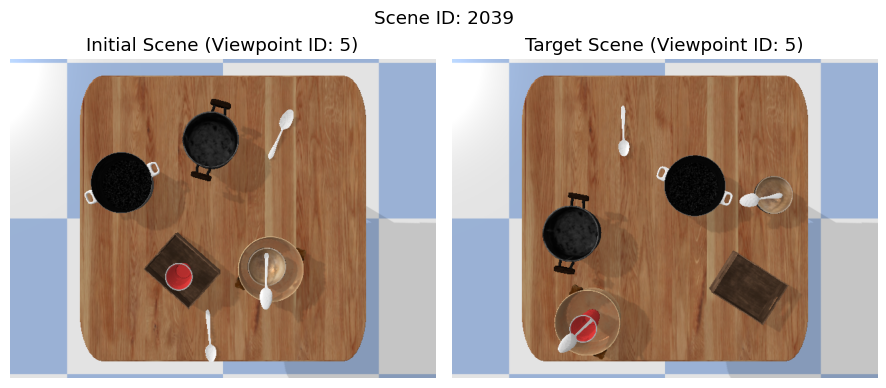

Consensus Filter complete. Final object count: 9.


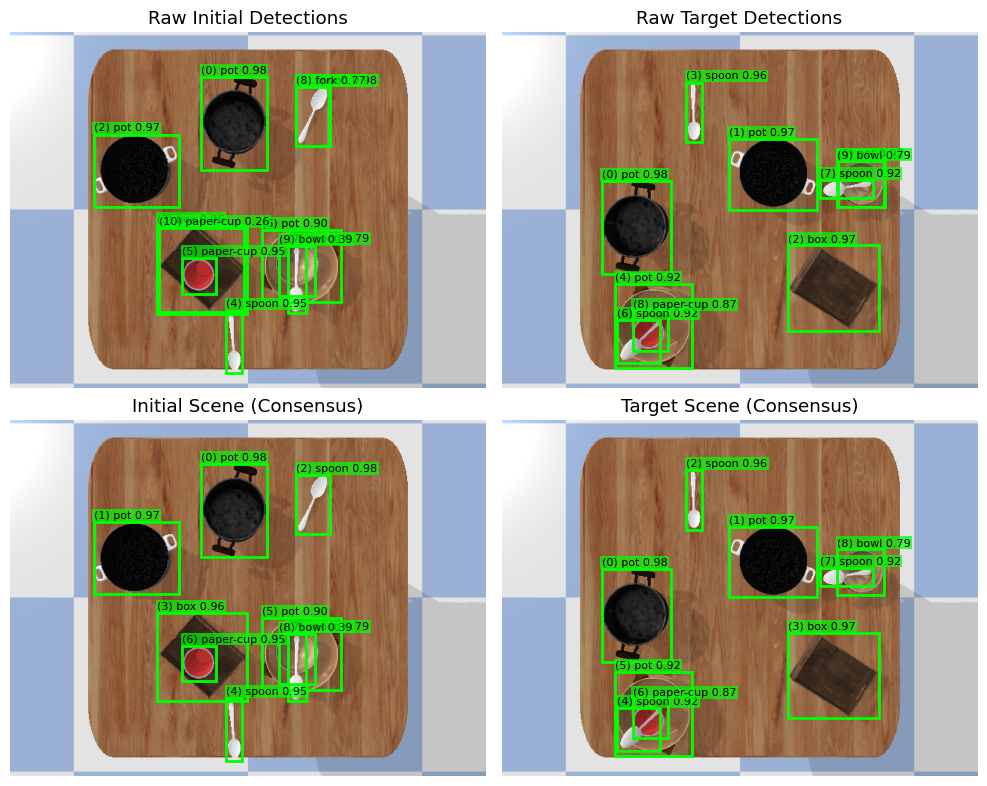

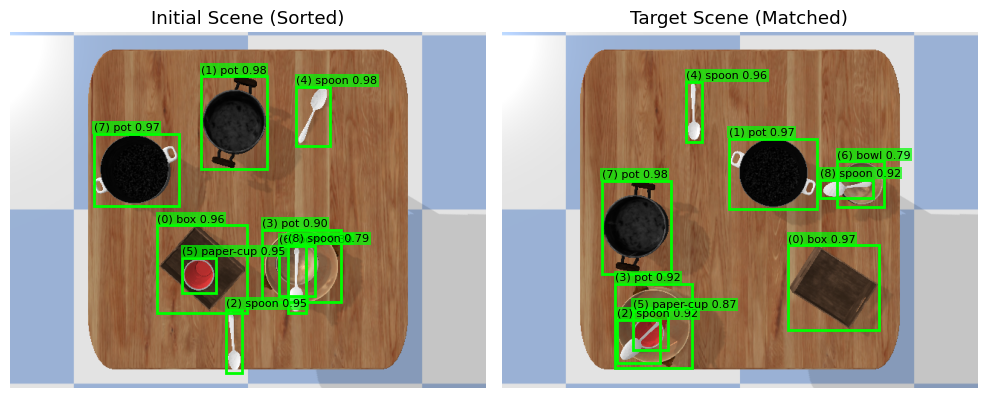


--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(5, 0), (6, 3), (8, 6)]
  - Detected:     [(5, 0), (6, 3), (8, 6)]
  - ✅ Correct

[Target Scene]
  - Ground Truth (by ID): [(4, 6), (5, 3), (8, 5)]
  - Detected (by ID):     [(2, 5), (5, 3), (8, 6)]
  - Comparing parent classes, grouped by child class...
  - ✅ Correct (Class-based match)
---------------------------------



In [7]:
from core.sim.rearrangement_loader import select_rearrangement_dir, visualize_rearrangement

folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=None, viewpoint_id=None)
visualize_rearrangement(dataset_dir, scene_id=scene_id,figsize=(9, 4), show_bbx=False)
utensils = {'fork', 'knife', 'spoon'}
fruits = {'apple', 'pear'}
bowls = {'bowl', 'pot'}
utensil_group = {k for k, v in class_map.items() if v in utensils}
fruit_group = {k for k, v in class_map.items() if v in fruits}
bowl_group = {k for k, v in class_map.items() if v in bowls}
confusable_groups = [utensil_group, fruit_group, bowl_group]
sim_scene_perception(
	yolo, model, folder_path, class_map, 
	conf_thresh=0.2, iou_thres=0.2,
	same_class_iou_thresh=0.7, cross_class_iou_thresh=0.7,
	confusable_groups=confusable_groups, verbose=2
);

0 -------------------------rearrangement_00132-------------------------

Consensus Filter complete. Final object count: 5.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(0, 4)]
  - Detected:     [(0, 4)]
  - ✅ Correct

[Target Scene]
  - Ground Truth (by ID): [(4, 2)]
  - Detected (by ID):     [(4, 2)]
  - ✅ Correct (Strict ID match)
---------------------------------



1 -------------------------rearrangement_00475-------------------------

Consensus Filter complete. Final object count: 5.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(3, 1)]
  - Detected:     [(3, 1)]
  - ✅ Correct

[Target Scene]
  - Ground Truth (by ID): [(2, 1)]
  - Detected (by ID):     [(2, 1)]
  - ✅ Correct (Strict ID match)
---------------------------------



2 -------------------------rearrangement_00451-------------------------

Consensus Filter complete. Final object count: 5.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(3, 2)]
  

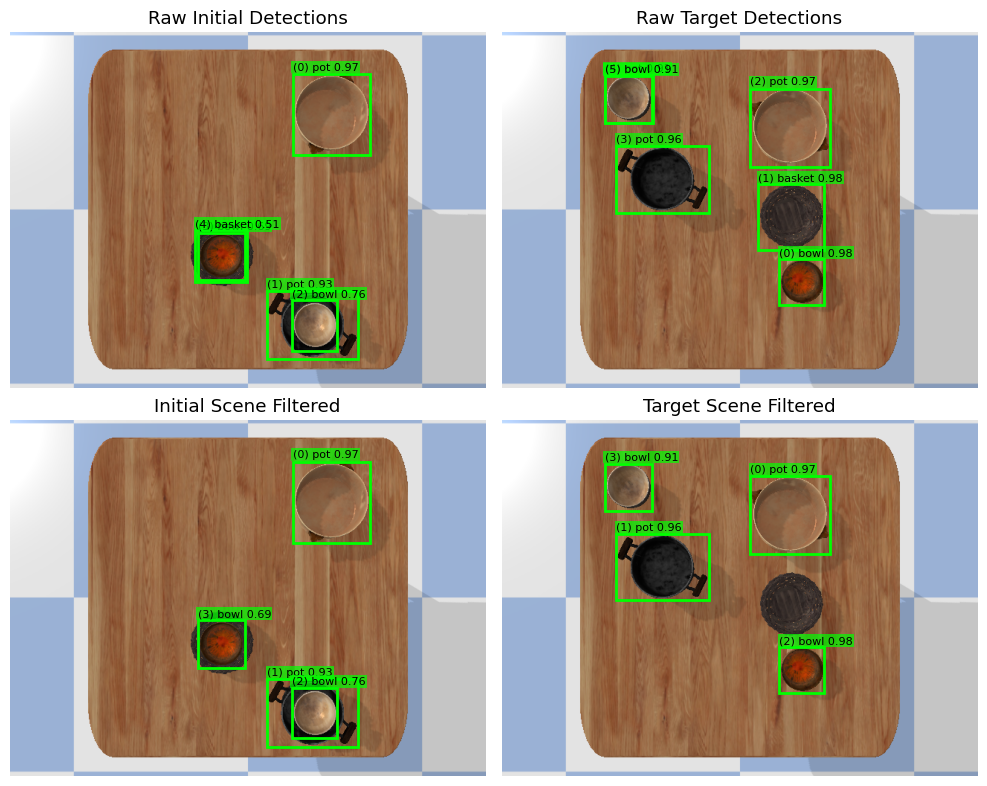

Skipping scene './dataset-sim\rearrangement_00435' due to error in initial detections: Object count mismatch. GT: 5, Detected: 4.


8 -------------------------rearrangement_00398-------------------------

Consensus Filter complete. Final object count: 5.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(2, 1), (4, 0)]
  - Detected:     [(2, 1), (4, 0)]
  - ✅ Correct

[Target Scene]
  - Ground Truth (by ID): [(4, 1)]
  - Detected (by ID):     [(2, 0)]
  - Comparing parent classes, grouped by child class...
  - ✅ Correct (Class-based match)
---------------------------------



9 -------------------------rearrangement_00324-------------------------

Consensus Filter complete. Final object count: 5.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(0, 2)]
  - Detected:     [(0, 2)]
  - ✅ Correct

[Target Scene]
  - Ground Truth (by ID): [(0, 1)]
  - Detected (by ID):     [(0, 1)]
  - ✅ Correct (Strict ID match)
---------------------------------



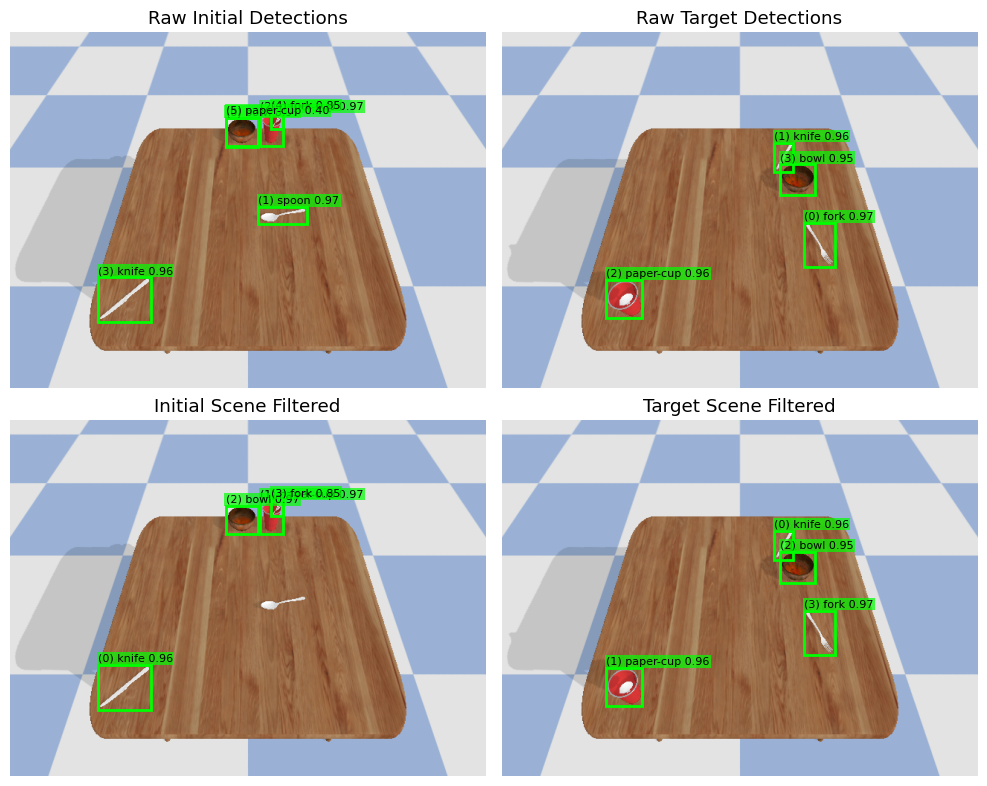

Skipping scene './dataset-sim\rearrangement_00320' due to error in initial detections: Object count mismatch. GT: 5, Detected: 4.


13 -------------------------rearrangement_00042-------------------------

Consensus Filter complete. Final object count: 5.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(3, 1)]
  - Detected:     [(3, 1)]
  - ✅ Correct

[Target Scene]
  - Ground Truth (by ID): No stacks
  - Detected (by ID):     No stacks
  - ✅ Correct (Strict ID match)
---------------------------------



14 -------------------------rearrangement_00472-------------------------

Consensus Filter complete. Final object count: 5.

--- Stack Relation Validation ---

[Initial Scene]
  - Ground Truth: [(0, 1)]
  - Detected:     [(0, 1)]
  - ✅ Correct

[Target Scene]
  - Ground Truth (by ID): [(0, 4)]
  - Detected (by ID):     [(0, 4)]
  - ✅ Correct (Strict ID match)
---------------------------------



15 -------------------------rearrangement_00304---------------------

In [ ]:
sampled_items = [
	'rearrangement_01038',
	'rearrangement_01357',
	'rearrangement_01095',
	'rearrangement_01260',
	'rearrangement_01407',
	'rearrangement_01224',
	'rearrangement_01098',
	'rearrangement_01391',
	'rearrangement_01291',
	'rearrangement_01252',
	'rearrangement_01079',
	'rearrangement_01327',
	'rearrangement_01484',
	'rearrangement_01272',
	'rearrangement_01163',
	'rearrangement_01370',
	'rearrangement_01215',
	'rearrangement_01253',
	'rearrangement_01399',
	'rearrangement_01144',
	'rearrangement_01425',
	'rearrangement_01322',
	'rearrangement_01400',
	'rearrangement_01311',
	'rearrangement_01161',
	'rearrangement_01170',
	'rearrangement_01281',
	'rearrangement_01207',
	'rearrangement_01310',
	'rearrangement_01274',
	'rearrangement_01257',
	'rearrangement_01187',
	'rearrangement_01423',
	'rearrangement_01003',
	'rearrangement_01490',
	'rearrangement_01024',
	'rearrangement_01333',
	'rearrangement_01122',
	'rearrangement_01052',
	'rearrangement_01057'
]

report_file = "results.json"
with open(report_file, 'w') as f:
	f.write('')

for i, item in enumerate(sampled_items):
	print(i, "-" * 25 + item + "-" * 25 + "\n")
	scene_id = int(item.split('_')[-1])
	folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=scene_id, viewpoint_id=None)
	# visualize_rearrangement(dataset_dir, scene_id=scene_id)

	result = sim_scene_perception(
		yolo, model, folder_path, class_map, 
		conf_thresh=0.2, iou_thres=0.2,
		same_class_iou_thresh=0.7, cross_class_iou_thresh=0.7,
		confusable_groups=confusable_groups, verbose=1
	);

	# store the results in a json file
	with open(report_file, 'a') as f:
		json.dump({scene_id: result}, f)
		f.write('\n')
	print("\n" + "=" * 80 + "\n")


# Real

In [ ]:
def real_scene_perception(
		yolo, model, init_img_path, trgt_img_path,
		confidence_thresh=0.4, iou_thresh=0.5,
		same_class_iou_thresh=0.5,
		cross_class_iou_thresh=0.5, confusable_groups=[],
		verbose=0,
	):
	class_map = {k: ('pot' if v == 'pan' else v) for k, v in yolo.names.items()}
	init_img = Image.open(init_img_path).convert("RGB")
	trgt_img  = Image.open(trgt_img_path).convert("RGB")
	
	# Get RAW detections
	raw_det_init = detect_objects(yolo, init_img, conf_thres=confidence_thresh, iou_thres=iou_thresh)
	raw_det_trgt = detect_objects(yolo, trgt_img, conf_thres=confidence_thresh, iou_thres=iou_thresh)

	# Use the Consensus Filter to get a consistent set of objects for each scene
	consistent_det_init, consistent_det_trgt = consensus_filter(
		raw_det_init,
		raw_det_trgt,
		same_class_iou_thresh=same_class_iou_thresh,
		cross_class_iou_thresh=cross_class_iou_thresh,
		confusable_groups=confusable_groups
	)

	# Use Instance Matching to sort the target detections to match the initial order
	sorted_det_init = consistent_det_init
	sorted_det_trgt = instance_matching(
		consistent_det_init, consistent_det_trgt
	)

	if verbose == 2:
		fig, axes = plt.subplots(2, 2, figsize=(10, 8))
		plot_detections(init_img_path, raw_det_init, class_map, ax=axes[0, 0], title="Raw Initial Detections")
		plot_detections(trgt_img_path, raw_det_trgt, class_map, ax=axes[0, 1], title="Raw Target Detections")
		plot_detections(init_img_path, sorted_det_init, class_map, ax=axes[1, 0], title="Initial Scene (Consensus)")
		plot_detections(trgt_img_path, sorted_det_trgt, class_map, ax=axes[1, 1], title="Target Scene (Consensus & Matched)")
		plt.tight_layout()
		plt.show()

	init_bboxes = [o["bbox"] for o in sorted_det_init]
	init_pairs = compute_scene_relation_graph(init_img_path, init_bboxes, model)
	print("Predicted initial scene relations:")
	for pair in init_pairs:
		print(f"\t{pair[0]} -> {pair[1]}")
	trgt_bboxes = [o["bbox"] for o in sorted_det_trgt]
	trgt_pairs = compute_scene_relation_graph(trgt_img_path, trgt_bboxes, model)
	print("Predicted target scene relations:")
	for pair in trgt_pairs:
		print(f"\t{pair[0]} -> {pair[1]}")
	
	return sorted_det_init, sorted_det_trgt, init_pairs, trgt_pairs

utensils = {'fork', 'knife', 'spoon'}
fruits = {'apple', 'pear'}
bowls = {'bowl', 'pot'}
utensil_group = {k for k, v in class_map.items() if v in utensils}
fruit_group = {k for k, v in class_map.items() if v in fruits}
bowl_group = {k for k, v in class_map.items() if v in bowls}
confusable_groups = [utensil_group, fruit_group, bowl_group]

real_scene_perception(
	yolo, model, "./images/i1.jpg", "./images/i2.jpg",
	confidence_thresh=0.2, iou_thresh=0.1,
	same_class_iou_thresh=0.8, cross_class_iou_thresh=0.8, 
	confusable_groups=confusable_groups, verbose=2,
);